## Programming Exercise 4: Neural Networks Learning

#### Setup

In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import fmin_cg, minimize
import matplotlib.pyplot as plt
from IPython.display import Image

data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')

In [2]:
# Padded with the ones at the beggining
X, y = np.c_[np.ones((data['X'].shape[0],1)), data['X']], data['y'] 
# Showing that the weights contains theta1 and theta2
weights.keys()

['Theta2', '__version__', '__header__', 'Theta1', '__globals__']

In [3]:
print weights['Theta1'].shape, weights['Theta2'].shape

(25, 401) (10, 26)


In [4]:
weights_vector = np.hstack([weights['Theta1'].ravel(), weights['Theta2'].ravel()])
print weights_vector.shape, X.shape, y.shape

(10285,) (5000, 401) (5000, 1)


#### Displaying the Data

In [5]:
def display_data(x):
    im_number = 200
    imv = np.empty((20,0))
    imag = []
    for i in range(im_number):
        im = np.reshape(x[i],(20,20)).T
        imv = np.append(imv,im,axis=1)
        if (i+1) % 20 == 0:
            imag.append(imv)
            imv = np.empty((20,0))
    image = np.concatenate((imag[:]),axis = 0)
    plt.axis('off')
    plt.imshow(image, cmap = 'gray_r')

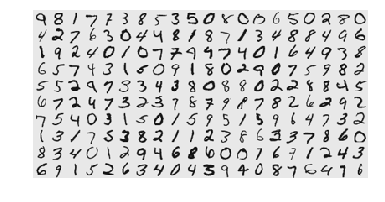

In [6]:
np.random.shuffle(data['X'])
display_data(data['X'])
plt.show()

#### Model Representation
Taken from the assignment's documentation:

![Model](img/Neural_Network_Model.png)

### Cost Function

#### Gradients

In [7]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def sigmoid_gradient(x):
    return sigmoid(x) * (1 - sigmoid(x))

#### The actual functions

In [8]:
def feed_forward(*args):
    X, theta1, theta2 = args
    
    # FF neural network
    ## Since X is already padded with 1 we don't need to add ones
    a1 = X 
    ## Calculating the Hidden Layer
    a2 = sigmoid(X.dot(theta1.T))
    ## Then adding 1s
    a2 = np.c_[np.ones((a2.shape[0],1)), a2]
    ## Calculating the hypothesis
    h_thx = sigmoid(a2.dot(theta2.T))
    
    return a1, a2, h_thx

##### Second implementation of the same functions, this time with theta combination
**fmin_cg** apprerently with have issues with the split of the thetas into a dict thus the approach outlined in the course is taken.

In [9]:
def calc_cost(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, reg):
    # Unrolling the Thetas
    nn_params = nn_params.reshape(-1)
    theta1, theta2 = np.split(nn_params, [(input_layer_size + 1) * hidden_layer_size])
    theta1 = np.reshape(theta1, (hidden_layer_size, (input_layer_size + 1)))
    theta2 = np.reshape(theta2, (num_labels, (hidden_layer_size + 1)))
    # Setuping some variables
    m = X.shape[0]
    J = 0
    theta1_grad = np.zeros((theta1.shape))
    theta2_grad = np.zeros((theta2.shape))
    
    # Regularization Function for the Cost
    regfunc = float(reg) / (2. * m) * (np.square(theta1).sum() + np.square(theta2).sum())
    
    # Getting the output from the feedforward
    _, _, h_thx = feed_forward(X, theta1, theta2)
    
    
#     y1 = np.zeros((m, num_labels))
#     for i in xrange(m):
#         y1[i, y[i,0] % 10] = 1
    
    
#     # J = np.trace(-np.log(h_thx).T.dot(y1) - np.log(1 - h_thx).T.dot(1 - y1)) / m
#     J = np.trace(-y1.T.dot(np.log(h_thx)) - (1 - y1.T).dot(np.log(1 - h_thx))) / m
    
    # Calculating the Cost Function
    for label in xrange(num_labels):
        y_label = y == label + 1 # since python indexing starts from 0
        h = h_thx[:,label].reshape(-1,1)
        J_label = - 1. / m * (np.log(h).T.dot(y_label) + np.log(1 - h).T.dot(1 - y_label))
        J = J + J_label
        
    return J + regfunc

def calc_grad(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, reg):
    
    # Unrolling the Thetas
    
#     theta1, theta2 = np.split(nn_params, [(input_layer_size + 1) * hidden_layer_size])
#     theta1 = np.reshape(theta1, (hidden_layer_size, (input_layer_size + 1)))
#     theta2 = np.reshape(theta2, (num_labels, (hidden_layer_size + 1)))

    theta1 = nn_params[:hidden_layer_size*(input_layer_size+1)].reshape(hidden_layer_size,(input_layer_size+1))
    theta2 = nn_params[hidden_layer_size*(input_layer_size+1):].reshape(num_labels,(hidden_layer_size+1))
    # Setuping some variables
    m = X.shape[0]
    
    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)
    
    # Getting Forward Function
    a1, a2, h_thx = feed_forward(X, theta1, theta2)
    
    # Getting all the labels
    y1 = np.zeros((m, num_labels))
    for i in xrange(m):
        y1[i, y[i,0] % 10] = 1

        
    # Thus
    delta3 = h_thx - y1
    z2 = a1.dot(theta1.T)
    delta2 = np.dot(delta3, theta2[:, 1:hidden_layer_size+1]) * sigmoid_gradient(z2)

    Delta1 = np.dot(delta2.T, a1) 
    Delta2 = np.dot(delta3.T, a2)    

    theta1_grad = Delta1 / m
    theta2_grad = Delta2 / m
    
    theta1_grad[:, 1:input_layer_size+1] = theta1_grad[:, 1:input_layer_size+1] + reg / m *  theta1[:, 1:input_layer_size+1]
    theta2_grad[:, 1:hidden_layer_size+1] = theta2_grad[:, 1:hidden_layer_size+1] + reg / m *  theta2[:, 1:hidden_layer_size+1]
    
    
    return np.hstack([theta1_grad.ravel(), theta2_grad.ravel()])

In [10]:
grads = calc_grad(weights_vector, 400, 25, 10, X, y, 1)

In [11]:
# Cost Function with Lambda = 0
cost_0 = calc_cost(weights_vector, 400, 25, 10, X, y, 0)
print "Should be about 0.287629: %f" % (cost_0)
# Cost Function with Lambda = 1; Should be equal to 0.383770
cost_1 = calc_cost(weights_vector, 400, 25, 10, X, y, 1)
print "Should be about 0.383770: %f" % (cost_1)

Should be about 0.287629: 0.287629
Should be about 0.383770: 0.384488


#### Random Initialization
Selecting values uniformly in the range [-0.12, 0.12]

In [12]:
def rand_init_weights_wg(l_in, l_out, num_labels):
    w_hidden_layer = np.random.uniform(0,1,(l_out, l_in + 1)) * 2 * 0.12 - 0.12
    w_output = np.random.uniform(0,1,(num_labels, w_hidden_layer.shape[0] + 1)) * 2 * 0.12 - 0.12
        
    # Combining to be consistent with the input of the nn cost function
    return np.hstack([w_hidden_layer.ravel(), w_output.ravel()])

##### Initial Thetas

In [13]:
initial_weights = rand_init_weights_wg(400, 25,10)

#### Checking the Numerical Gradients

In [14]:
def calc_num_grad(J, theta):
    
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    
    e = 0.0001

    for p in xrange(1, theta.size):
        perturb[p] = e
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)
        
        numgrad[p] = (loss2 - loss1) / (2 * e)
        perturb[p] = 0
    
    return numgrad
        
def gradient_check(reg):
    # Define the initial parameters for the test
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # Initializing Theta
    initial_grad_test = rand_init_weights_wg(input_layer_size, hidden_layer_size, num_labels)
        
    # Generating X
    X = np.random.rand(m, input_layer_size)
    # Padding X with ones
    X = np.c_[np.ones((X.shape[0],1)), X]
    # Generating Y
    y = np.array([np.mod(i,num_labels) for i in xrange(0,m)]).reshape(-1,1)
    
    # Calculating the resulting gradient
    grad = calc_grad(initial_grad_test, input_layer_size, hidden_layer_size, num_labels, X, y, reg)
    
    num_grad = calc_num_grad(lambda theta: calc_cost(theta, input_layer_size, hidden_layer_size, num_labels, X, y, reg), initial_grad_test)
    
    print 'Calculated Gradient, Numerical Gradient'
    for i in range(len(grad)):
        print (grad[i], num_grad[i]) 
    
    print 
    diff = np.linalg.norm(num_grad - grad) / np.linalg.norm(num_grad + grad)
    print 'Relative Difference: '
    print diff

In [15]:
gradient_check(0)

Calculated Gradient, Numerical Gradient
(0.012335247049859917, 0.0)
(0.006614122618189772, 0.0099233789496722125)
(0.0027294765461703166, 0.0087126885550681266)
(0.0099114365862009064, 0.014207358174367357)
(-0.0074626682401716616, -0.0079054036472570033)
(-0.0055252883488035162, -0.0021365048108457074)
(0.0018856240440172992, -0.004386034391234972)
(-0.0090430304639973168, -0.0021491812018936685)
(-0.0090685233641696426, -0.012944992022756452)
(-0.0053776629632929576, -0.00516219198720691)
(0.0001829724244535395, -0.0066098169226869175)
(-0.0083200422989246799, -0.0068395616170668916)
(-0.0027969425655654432, -0.0059480155756297393)
(-0.0023253930308095561, -0.0038011275793614629)
(-0.003091356458940351, 0.0007286211101131812)
(-0.0038673881891901881, -0.0060139134516745685)
(0.0077948553926536308, 0.012253752907920301)
(0.0043602742149841779, 0.0053944712941067507)
(0.00082178805509576232, 0.0056348239541037515)
(0.0066263482257577846, 0.0075176680280897301)
(0.083713730503748057, 0.

The relative difference above should be smaller than 1e-9

#### Learning parameters using fmincg

In [16]:
# Theta has been initialized above
reg = 1
max_iter = 400
labels = 10
hls = 25 # Hidden Layer Size
ils = 400 # Input Layer Size

In [17]:
print X.shape, y.shape

(5000, 401) (5000, 1)


In [ ]:
# calc_weights = fmin_cg(calc_cost, initial_weights, fprime=calc_grad, args=(ils, hls, labels, X,y, reg), maxiter = max_iter, disp=1)
calc_weights = minimize(calc_cost, initial_weights, args = (ils, hls, labels, X, y, reg), method=None, jac=calc_grad, options={'maxiter':max_iter})

In [ ]:
print calc_weights.x

#### Prediction

In [ ]:
def predict(theta, X, *args):
    
    input_layer_size, hidden_layer_size, num_labels = args
    # Unrolling the thetas
    print type(theta)
    theta1, theta2 = np.split(theta, [(input_layer_size + 1) * hidden_layer_size])
    theta1 = np.reshape(theta1, (hidden_layer_size, (input_layer_size + 1)))
    theta2 = np.reshape(theta2, (num_labels, (hidden_layer_size + 1)))    
    
    _, _, htxh = feed_forward(X, theta1, theta2)
    
    return np.argmax(htxh, axis=1).reshape(-1,1)

def accurate(prediction, y):
    return sum(prediction == y%10) / float(y.shape[0])*100

In [ ]:
predictions = predict(calc_weights.x, X, ils, hls, labels)
accuracy = accurate(predictions, y)

In [ ]:
print accuracy